In [104]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt

# Libraries for model training
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [105]:
ticker = "MSFT"

df = pd.read_csv(f'data/stocks/{ticker}.csv', parse_dates=['Date'])
df["Difference"] = df["Close"].diff()
df["Movement"] = df.apply(lambda x: 1 if x["Difference"] > 0 else 0, axis=1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference,Movement
0,1986-03-13,0.088542,0.101562,0.088542,0.097222,0.062378,1031788800,NaN,0
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064606,308160000,0.003472,1
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065720,133171200,0.001736,1
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064049,67766400,-0.002604,0
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062935,47894400,-0.001736,0


In [106]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, df, start = dt.datetime(1990,1,1), end = dt.datetime(2024,1,1)):
    # df["Name"] = company
    date_filtered_data = df[(df['Date'] > start) & (df['Date'] < end)]
    return date_filtered_data

df = specific_data(ticker, df)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference,Movement
962,1990-01-02,0.605903,0.616319,0.598090,0.616319,0.395434,53033600,0.012153,1
963,1990-01-03,0.621528,0.626736,0.614583,0.619792,0.397661,113772800,0.003472,1
964,1990-01-04,0.619792,0.638889,0.616319,0.638021,0.409357,125740800,0.018229,1
965,1990-01-05,0.635417,0.638889,0.621528,0.622396,0.399332,69564800,-0.015625,0
966,1990-01-08,0.621528,0.631944,0.614583,0.631944,0.405459,58982400,0.009549,1


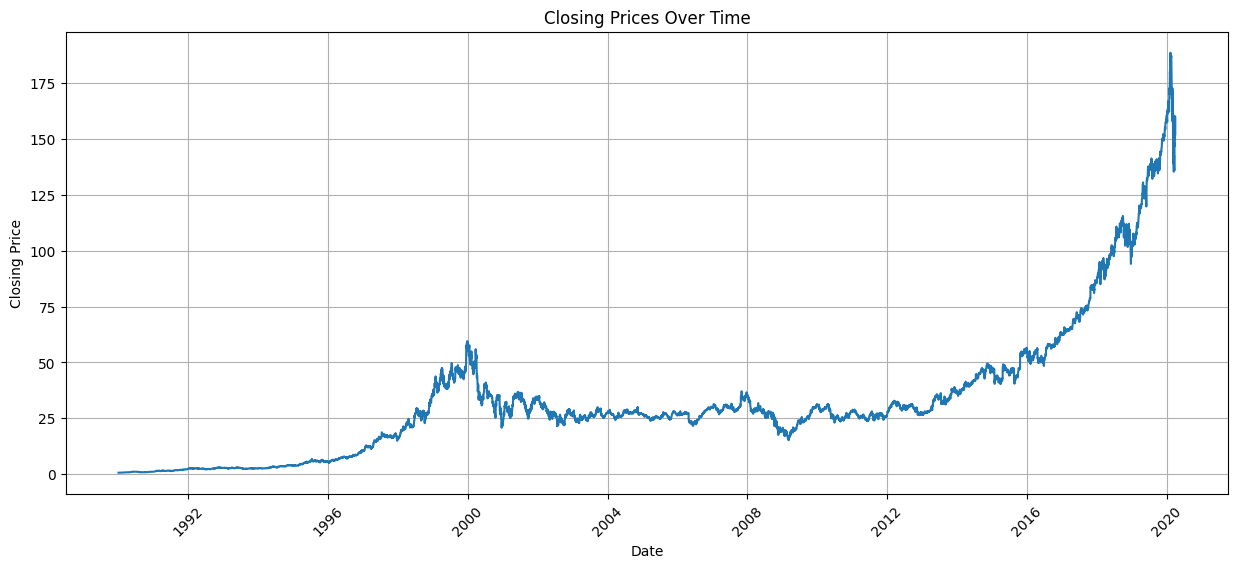

In [107]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

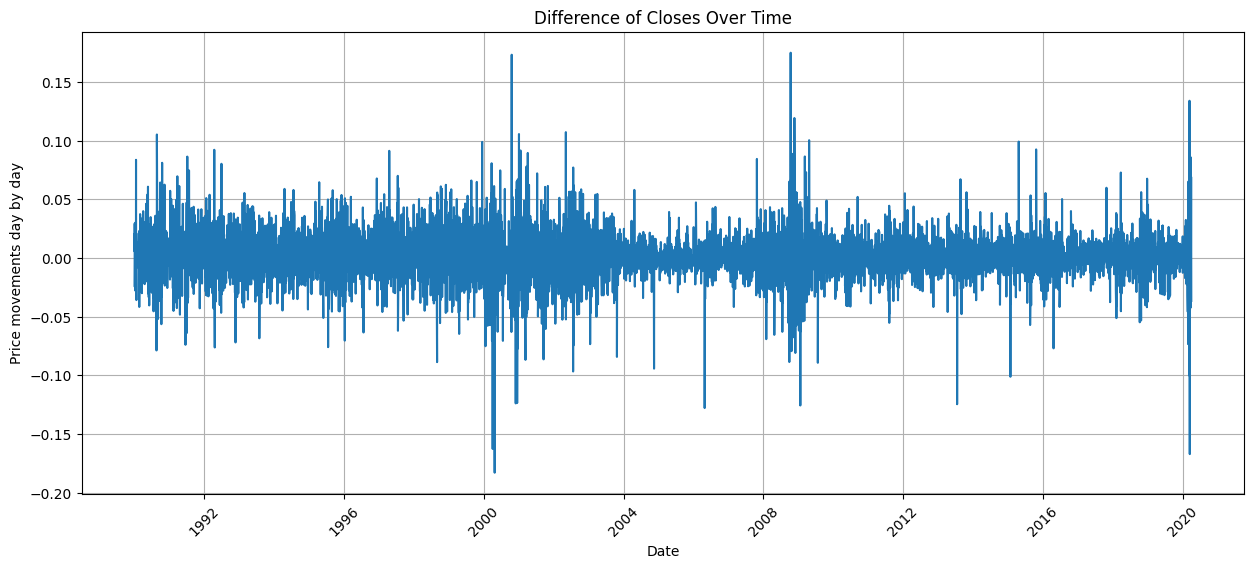

In [108]:
# Convert 'Date' column to datetime

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df["Difference"] / df["Open"])
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

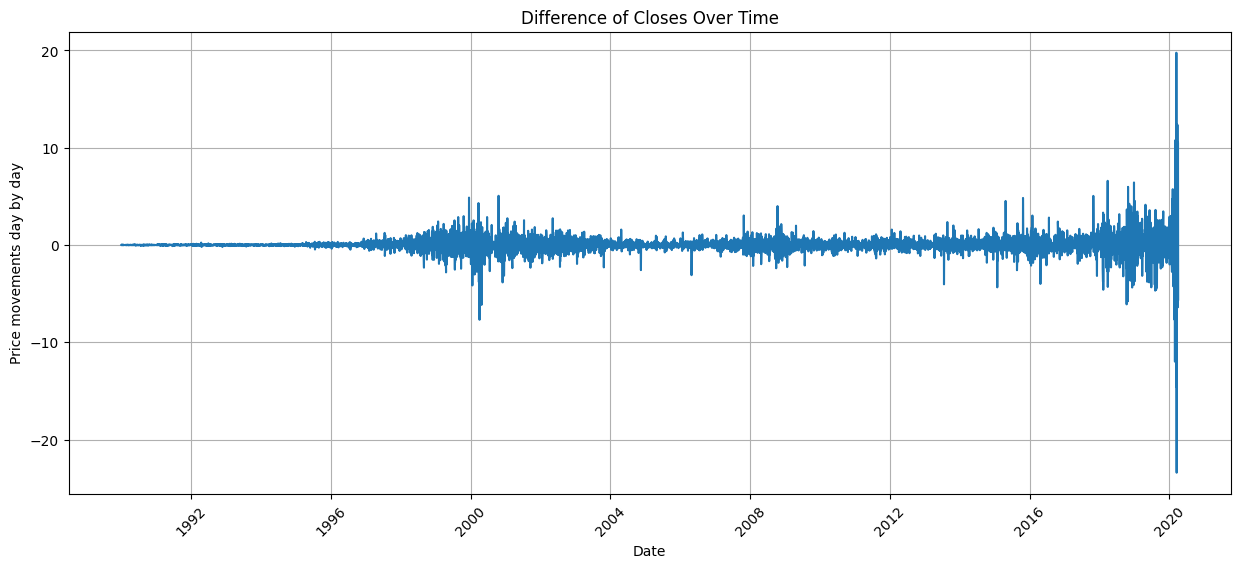

In [109]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Difference'])
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [110]:
scaler = MinMaxScaler()
close_scaler = MinMaxScaler()
without_date = df.drop( "Date", axis="columns")

df_train, df_test = train_test_split(without_date, test_size=0.2, shuffle=False)

close_scaler.fit(np.array(df_train["Close"]).reshape(-1,1))
print(f"{close_scaler.scale_}, {close_scaler.min_}, ")
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

print(scaled_train.shape)
print(scaled_test.shape)

[0.01695938], [-0.01014324], 
(6097, 8)
(1525, 8)


In [111]:
past = 8

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(past, len(scaled_train)):
    X_train.append(scaled_train[i - past:i])
    y_train.append(scaled_train[i][-1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(past, len(scaled_test)):
    X_test.append(scaled_test[i - past:i])
    y_test.append(scaled_test[i][-1])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(6089, 8, 8)
(6089,)
Testing set size:-
(1517, 8, 8)
(1517,)


(None, None)

In [112]:
y_Train = tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='float32'
)
y_Test = tf.keras.utils.to_categorical(
    y_test, num_classes=2, dtype='float32'
)

In [113]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 64 units, input shape, and return sequences
model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Flatten())
# Second LSTM layer with 64 units and return sequences
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.2))

# Third LSTM layer with 64 units
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(2, activation='sigmoid'))

model.summary()


ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 8, 8)

In [68]:
model.compile(loss='mse',optimizer='adam')

In [69]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_Train,
          validation_split=0.2,
          epochs=24,
          batch_size=8,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/24
609/609 [==============================] - 2s 2ms/step - loss: 0.2510 - val_loss: 0.2516
Epoch 2/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2504 - val_loss: 0.2499
Epoch 3/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2499 - val_loss: 0.2502
Epoch 4/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2500 - val_loss: 0.2502
Epoch 5/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2500 - val_loss: 0.2502
Epoch 6/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2494 - val_loss: 0.2503
Epoch 7/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2494 - val_loss: 0.2508
Epoch 8/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2489 - val_loss: 0.2507
Epoch 9/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2493 - val_loss: 0.2506
Epoch 10/24
609/609 [==============================] - 1s 2ms/step - loss: 0.2488 - val_loss: 0.2506

In [77]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

48/48 [==============================] - 0s 1ms/step


In [100]:
# Transform back to original form
# train_predict=scaler.inverse_transform(train_predict)
# test_predict=scaler.inverse_transform(test_predict)

train_movement=np.array(df_train["Movement"][past:])
test_movement=np.array(df_test["Movement"][past:])
print(train_movement.shape)
print(test_movement.shape)

train_decision = np.argmax(train_predict, axis=1)
test_decision = np.argmax(test_predict, axis=1)
print(train_decision.shape)
print(test_decision.shape)

counter = 0
good = 0
for i in range(0, len(train_movement)):
    if train_movement[i] == train_decision[i]:
        good +=1
    counter+=1
print(f"{good/counter}")

counter = 0
good = 0
for i in range(0, len(test_movement)):
    if train_movement[i] == train_decision[i]:
        good +=1
    counter+=1
print(f"{good/counter}")


(6083,)
(1511,)
(6083,)
(1511,)
0.5078086470491534
0.5433487756452681


ValueError: could not broadcast input array from shape (12166,) into shape (6083,)

(7622,)
              0
0      8.398410
1      8.408944
2      8.414731
3      8.420286
4      8.432323
...         ...
1506  74.021858
1507  76.272369
1508  77.055145
1509  78.148384
1510  78.236778

[7594 rows x 1 columns]


      Predicted       Close  Difference  Predicted difference  Same Direction
0      8.398410    0.630208         NaN                   NaN           False
1      8.408944    0.623264   -0.006944              0.010534           False
2      8.414731    0.630208    0.006944              0.005787            True
3      8.420286    0.630208    0.000000              0.005555           False
4      8.432323    0.630208    0.000000              0.012037           False
...         ...         ...         ...                   ...             ...
1506  74.021858  156.110001    9.190002              1.670479            True
1507  76.272369  149.699997   -6.410004              2.250511           False
1508  77.055145  160.229996   10.529999              0.782776            True
1509  78.148384  157.710007   -2.519989              1.093239           False
1510  78.236778  152.110001   -5.600006              0.088394           False

[7594 rows x 5 columns]


In [174]:
import collections
counter = collections.Counter(combined["Same Direction"])
print(counter)

Counter({True: 3801, False: 3793})


In [175]:
counter[True] / (counter[False] + counter[True])

0.5005267316302344